In [1]:
import sys
sys.path.insert(0,'..')
from run import Prepro
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import pandas as pd
# import tensorly as tl #tensorly package
# from tensorly.decomposition import tucker #tucker decomp package
import utils_tensor as utils 

In [2]:
pd.read_csv('../cluster_results/xgb_tensor_accuracy.csv')

,base_intensity_accu,compression_error,max_depth,past_n_steps,pred_n_steps,xgb_intensity_accu
0,0.797,113.513023,5,8,2,0.813


In [3]:
#load data 
#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('../data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('../data/y_50_20_60_3years_v2.npy', allow_pickle = True) 
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True) 

In [4]:
print(vision_data.shape)
print(y.shape)

(83, 60, 3, 3, 25, 25)
(83, 60, 11)


In [48]:
train_test_split = 0.8 #how much train test data
predict_at = 8 #steps_out
window_size = 16 #how many timesteps from the past to take ie steps_in

train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = predict_at, window_size=window_size)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3071, 16, 9, 25, 25])
X_stat torch.Size([3071, 16, 10])
target_displacement torch.Size([3071, 8, 2])
target_intensity torch.Size([3071])
target_intensity_cat torch.Size([3071])
target_intensity_cat_baseline torch.Size([3071])
Keeping 2481 samples out of the initial 3071.
Reshaping the displacement target...


In [49]:
print(vision_data.shape)
print(x_stat_train.shape)
print(x_viz_train.shape)

(83, 60, 3, 3, 25, 25)
torch.Size([1984, 16, 10])
torch.Size([1984, 16, 9, 25, 25])


In [50]:
# utils.get_norms_4d(x_viz_train.numpy())

In [51]:
#function intaking x_stat, x_viz and concat them according to ranks 
def concat_stat_viz(x_stat_train, x_viz_train, reduced_ranks): #third arg is vision tensor's dimensions 
    #reshape tabular data 
    X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)

    #compress vision data according to reduced_ranks 
    viz = np.zeros((x_viz_train.shape[0], np.prod(reduced_ranks)))
    avg_error = 0 
    for i in range(x_viz_train.shape[0]):
        viz[i,:], error = utils.viz_to_arr(x_viz_train[i].numpy(), reduced_ranks)
        avg_error += error 
    X_train = np.concatenate((X_train.numpy(), viz), axis=1)
    compression_error = avg_error/x_viz_train.shape[0]
    
    return X_train, compression_error 

#concat viz with tabular 
X_train, error =utils.concat_stat_viz(x_stat_train, x_viz_train, reduced_ranks=[10,7,10,10])
X_test, error  =concat_stat_viz(x_stat_test, x_viz_test, reduced_ranks=[10,7,10,10])


In [52]:
#standardize x:
def standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test):
    means = x_viz_train.mean(dim=(0, 1, 3, 4))
    stds = x_viz_train.std(dim=(0, 1, 3, 4))

    means_stat = x_stat_train.mean(dim=(0, 1))
    stds_stat = x_stat_train.std(dim=(0, 1))

    for i in range(len(means)):
        x_viz_train[:, :, i] = (x_viz_train[:, :, i] - means[i]) / stds[i]
        x_viz_test[:, :, i] = (x_viz_test[:, :, i] - means[i]) / stds[i]

    for i in range(len(means_stat)):
        x_stat_train[:, :, i] = (x_stat_train[:, :, i] - means_stat[i]) / stds_stat[i]
        x_stat_test[:, :, i] = (x_stat_test[:, :, i] - means_stat[i]) / stds_stat[i]
    return x_viz_train, x_viz_test, x_stat_train, x_stat_test

#standardize y: 
def standardize_y(y_train, y_test):
    y_train = y_train.numpy()
    y_test = y_test.numpy()
    mean = y_train.mean()
    std = y_train.std()
    y_train = (y_train-mean)/std
    y_test = (y_test-mean)/std
    return y_train, y_test, mean , std 

x_viz_train, x_viz_test, x_stat_train, x_stat_test = standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test)
tgt_intensity_train,tgt_intensity_test, mean_intensity, std_intensity  = standardize_y(tgt_intensity_train,tgt_intensity_test)


In [53]:
# #get training and test tensors
# ##maybe we don't have to call this for each prediction period, since x is the same, just y different? 
# # train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = predict_at, window_size=window_size)
# # x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
# # x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

#need to standardize 

# # #concat viz with tabular 
# # X_train, compress_error =concat_stat_viz(x_stat_train, x_viz_train, reduced_ranks)
# # X_test, _ =concat_stat_viz(x_stat_test, x_viz_test, reduced_ranks)

# #run XGB on intensity
xgb = XGBRegressor(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_train)
yhat = xgb.predict(X_test)
mae_intensity = mean_absolute_error(tgt_intensity_test*std_intensity + mean_intensity, yhat*std_intensity+mean_intensity) 



# # xgb = XGBRegressor(max_depth=5, n_estimators=80)
# # xgb.fit(X_train, tgt_displacement_train[:,0])
# # yhat = xgb.predict(X_test)
# # mae_dx = mean_absolute_error(tgt_displacement_test[:,0], yhat) 
# # mae_dx

# mae_intensity
mae_intensity


12.021875

In [ ]:
def run_xgb(vision_data, stat_data, window_size, predict_at, max_depth, reduced_ranks):
    #get training and test tensors
    ##maybe we don't have to call this for each prediction period, since x is the same, just y different?
    train_test_split=0.8
    train_tensors, test_tensors = Prepro.process(vision_data, stat_data, train_test_split, predict_at = predict_at, window_size=window_size)
    x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
    x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

    #standardize:
    means = x_viz_train.mean(dim=(0, 1, 3, 4))
    stds = x_viz_train.std(dim=(0, 1, 3, 4))

    means_stat = x_stat_train.mean(dim=(0, 1))
    stds_stat = x_stat_train.std(dim=(0, 1))

    for i in range(len(means)):
        x_viz_train[:, :, i] = (x_viz_train[:, :, i] - means[i]) / stds[i]
        x_viz_test[:, :, i] = (x_viz_test[:, :, i] - means[i]) / stds[i]

    for i in range(len(means_stat)):
        x_stat_train[:, :, i] = (x_stat_train[:, :, i] - means_stat[i]) / stds_stat[i]
        x_stat_test[:, :, i] = (x_stat_test[:, :, i] - means_stat[i]) / stds_stat[i]

    #concat viz with tabular
    X_train, compress_error =utils.concat_stat_viz(x_stat_train, x_viz_train, reduced_ranks)
    X_test, _ =utils.concat_stat_viz(x_stat_test, x_viz_test, reduced_ranks)

    #run XGB on intensity
    xgb = XGBRegressor(max_depth=5, n_estimators=80)
    xgb.fit(X_train, tgt_intensity_train)
    yhat = xgb.predict(X_test)
    mae_intensity = mean_absolute_error(tgt_intensity_test, yhat)
    
    mean_intensity = tgt_intensity_train.mean()
    std_intensity = tgt_intensity_train.std()

    #run XGB on displacement
    xgb = XGBRegressor(max_depth=5, n_estimators=80)
    xgb.fit(X_train, tgt_displacement_train[:,0])
    yhat = xgb.predict(X_test)
    mae_dx = mean_absolute_error(tgt_displacement_test[:,0], yhat)

    xgb = XGBRegressor(max_depth=5, n_estimators=80)
    xgb.fit(X_train, tgt_displacement_train[:,1])
    yhat = xgb.predict(X_test)
    mae_dy = mean_absolute_error(tgt_displacement_test[:,1], yhat)

    # #run XGB on intensity category
    xgb = XGBClassifier(max_depth=max_depth, n_estimators=80)
    xgb.fit(X_train, tgt_intensity_cat_train)
    yhat = xgb.predict(X_test)
    score_xgb = accuracy_score(tgt_intensity_cat_test, yhat)
    score_base = accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test)

    return np.round(mae_intensity,3) , np.round(mae_dx,3), np.round(mae_dy,3), np.round(,3), np.round(score_xgb,3), np.round(score_base,3), compress_error

In [9]:
np.arange(2,20,2)

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

In [8]:
def run_xgb(window_size, predict_at, reduced_ranks = [5,7,10,10]):
    #get training and test tensors
    ##maybe we don't have to call this for each prediction period, since x is the same, just y different? 
    train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = predict_at, window_size=window_size)
    x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
    x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors
    
    #concat viz with tabular 
    X_train, compress_error =concat_stat_viz(x_stat_train, x_viz_train, reduced_ranks)
    X_test, _ =concat_stat_viz(x_stat_test, x_viz_test, reduced_ranks)
    
    #run XGB on intensity
    xgb = XGBRegressor(max_depth=max_depth, n_estimators=80)
    xgb.fit(X_train, tgt_intensity_train)
    yhat = xgb.predict(X_test)
    score_xgb = mean_absolute_error(tgt_intensity_test, yhat)    
    
    #run XGB on displacement 
    xgb2 = XGBRegressor(max_depth=5, n_estimators=80)
    xgb2.fit(X_train, tgt_displacement_train)
    yhat2 = xgb.predict(X_test)
    disp_xgb = mean_absolute_error(tgt_displacement_test, yhat2) 
    disp_base = mean_absolute_error(tgt_intensity_cat_test, tgt_displacement_baseline_test)
    
    return intensity_xgb, intensity_base, disp_xgb, disp_base, compress_error 

    
run_xgb(window_size=8, predict_at=2, reduced_ranks = [5,7,10,10])

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([4233, 8, 9, 25, 25])
X_stat torch.Size([4233, 8, 10])
target_displacement torch.Size([4233, 2, 2])
target_intensity torch.Size([4233])
target_intensity_cat torch.Size([4233])
target_intensity_cat_baseline torch.Size([4233])
Keeping 3641 samples out of the initial 4233.
Reshaping the displacement target...


KeyboardInterrupt: 

In [4]:
# # #vision data to array data using tensor decomp 
# # def viz_to_arr(tensor, reduced_ranks):
# #     #low rank decomp 
# #     core, factors = tucker(tensor, reduced_ranks)
# #     out_arr = core.flatten()
    
# #     #calculate approximation error
# #     approx = tucker_to_tensor(core, factors)
# #     approx_error = tl.norm(approx-tensor)/tl.norm(tensor)*100  #euclidean norm 
    
# #     return out_arr,  approx_error

# out_arr, error = viz_to_arr(x_viz_train[50].numpy(), [5,7,10,10])
# print(error)

(25, 25)

In [5]:
x_stat_train[0,1,:]
#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 


#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
#'STORM_SPEED', 'STORM_DIR', 'storm_category', 'basin_EP', 'basin_NI',
#'basin_SI', 'basin_SP', 'basin_WP', 'nature_DS', 'nature_ET',
#'nature_MX', 'nature_NR', 'nature_SS', 'nature_TS'
#'STORM CATEGORY', 
#'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y'

tensor([ 6.8000e+00, -1.7200e+02,  5.5000e+01,  9.9400e+02,  2.1470e+03,
         8.0000e+00,  3.2100e+02,  1.0000e+00,  4.1247e-01, -3.0800e-01])

In [32]:
tgt_displacement_train.shape

torch.Size([2514, 2])

In [19]:
x_viz_train.shape

torch.Size([2514, 8, 9, 25, 25])

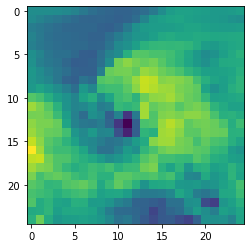

In [57]:
plt.imshow(x_viz_train[20,7,5,:,:])

In [35]:
import tensorly as tl #tensorly package
from tensorly.decomposition import tucker #tucker decomp package
# import hosvd as hosvd
test_tensor = x_viz_train[30].numpy()
# print(test_tensor.shape)

# core, factors = tucker(test_tensor)
# print(core.shape)
# norms = get_norms_4d(test_tensor)
# print((norms.cumsum()/norms.sum()).head(10)) #'cumsum of norms'

# #try with rank [5,5,5]
# core, factors = tucker(test_tensor, [5,5,5,5])
# core.flatten()

# #reconstruction accuracy: 
# approx = tucker_to_tensor(core, factors)
# # print(hosvd.error(test_tensor, approx)) 

#function to calculate dimensional norms  
def get_norms_4d(tensor):   
  
    tensor_shape = tensor.shape
    dim = len(tensor.shape) 
    
    core, _ = tucker(tensor, ranks=tensor_shape)
     
    norm0=[]
    for i in range(core.shape[0]):
        norm0.append(tl.norm(core[i,:,:,:]))  

    norm1=[]
    for i in range(core.shape[1]):
        norm1.append(tl.norm(core[:,i,:,:]))  

    norm2=[]
    for i in range(core.shape[2]):
        norm2.append(tl.norm(core[:,:,i,:]))  
    
    norm3 = [] 
    for i in range(core.shape[2]):
        norm3.append(tl.norm(core[:,:,:,i])) 
    
    norms = pd.concat([pd.Series(norm0),pd.Series(norm1),pd.Series(norm2),pd.Series(norm3)], axis=1) 
    norms_cumsum = norms.cumsum()/norms.sum()#'cumsum of norms'
    return norms_cumsum 

#function reconstruct tensor given core and factors
def tucker_to_tensor(core, factors):
    tensor = core.copy()
    dim = len(core.shape)
    for i in range(dim):
        tensor = tl.tenalg.mode_dot(tensor, factors[i], mode=i)
    return tensor


In [33]:
#vision data to array data using tensor decomp 
def viz_to_arr(tensor, reduced_ranks):
    #low rank decomp 
    core, factors = tucker(tensor, reduced_ranks)
    out_arr = core.flatten()
    
    #calculate approximation error
    approx = tucker_to_tensor(core, factors)
    approx_error = tl.norm(approx-tensor)/tl.norm(tensor)*100  #euclidean norm 
    
    return out_arr,  approx_error

out_arr, error = viz_to_arr(x_viz_train[50].numpy(), [5,7,10,10])
print(error)

7.672566920518875


In [36]:
get_norms_4d(x_viz_train[50].numpy())

,0,1,2,3
0,0.768218,0.486046,0.485992,0.531203
1,0.867152,0.629811,0.643634,0.671907
2,0.908902,0.762647,0.740847,0.752590
3,0.937377,0.826369,0.791783,0.815600
4,0.961314,0.884546,0.827399,0.846564
5,0.977005,0.928143,0.853319,0.874254
6,0.989584,0.963088,0.873027,0.891845
7,1.000000,0.991416,0.890445,0.906335
8,NaN,1.000000,0.904175,0.918492
9,NaN,NaN,0.917839,0.929491


In [34]:
#function intaking x_stat, x_viz and concat them according to ranks 
def concat_viz_tensor(x_stat_train, x_viz_train, reduced_ranks): #third arg is vision tensor's dimensions 
    #get tabular data 
    X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)

    #get vision data according to tensor_ranks 
    viz = np.zeros((x_viz_train.shape[0], np.prod(reduced_ranks)))
    avg_error = 0 
    for i in range(x_viz_train.shape[0]):
        viz[i,:], error = viz_to_arr(x_viz_train[i].numpy(), reduced_ranks)
        avg_error += error 
    print('average tensor approx pct error is', avg_error/x_viz_train.shape[0])   
    X_train = np.concatenate((X_train.numpy(), viz), axis=1)
    return X_train 

#concat viz with tabular 
X_train =concat_viz_tensor(x_stat_train, x_viz_train, reduced_ranks=[5,7,10,10])
X_test =concat_viz_tensor(x_stat_test, x_viz_test, reduced_ranks=[5,7,10,10])

average tensor approx pct error is 16.294653242929595
average tensor approx pct error is 15.749946799845878


In [37]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_cat_train)
yhat = xgb.predict(X_test)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5453100158982512
Baseline score 0.45151033386327505


In [34]:
x_viz_train.shape
#samples * timesteps * number of maps * size of map * size of map

torch.Size([2514, 8, 9, 25, 25])

In [35]:
x_stat_train.shape
#samples * number of past timesteps * number of features

torch.Size([2514, 8, 10])

In [42]:
y.shape
#number of storms * number of timesteps * number of features

(83, 60, 11)

In [43]:
X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)
X_test = x_stat_test.reshape(x_stat_test.shape[0], -1)
X_train.shape

torch.Size([2514, 80])

In [44]:
X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)
print(X_train_vision.shape)
print(X_test_vision.shape)

torch.Size([2514, 45000])
torch.Size([629, 45000])


In [39]:
X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

In [40]:
print(tgt_intensity_cat_train.shape)
print(tgt_intensity_cat_test.shape)

torch.Size([2514])
torch.Size([629])


In [41]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_cat_train)
yhat = xgb.predict(X_test)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5405405405405406
Baseline score 0.45151033386327505


In [139]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(x_stat_train.reshape(x_stat_train.shape[0], -1), tgt_intensity_cat_train)
yhat = xgb.predict(x_stat_test.reshape(x_stat_test.shape[0], -1))
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.5405405405405406
Baseline score 0.45151033386327505


In [45]:
xgb = XGBClassifier(max_depth=6, n_estimators=200)
xgb.fit(X_train_tab_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_tab_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

KeyboardInterrupt: 

In [ ]:
xgb = XGBClassifier(max_depth=4, n_estimators=80)
xgb.fit(X_train_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

In [55]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, tgt_intensity_cat_train)
yhat = rf.predict(X_test)
print("RF score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

RF score 0.8814372999709048
Baseline score 0.8910386965376782


In [68]:
xgb_x = XGBRegressor(max_depth=3, n_estimators=80)
xgb_y = XGBRegressor(max_depth=3, n_estimators=80)
xgb_x.fit(X_train, tgt_displacement_train[:,0])
xgb_y.fit(X_train, tgt_displacement_train[:,1])

yhat_x = xgb_x.predict(X_test)
yhat_y = xgb_y.predict(X_test)
print("XGB x score", mean_absolute_error(tgt_displacement_test[:,0], yhat_x))
print("XGB y score", mean_absolute_error(tgt_displacement_test[:,1], yhat_y))
#be careful for interpretation because the displacement is in degree + standardized + I did not code any baseline

[22:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB x score 0.34135345
XGB y score 0.33949062


In [69]:
tgt_displacement_train.max()

tensor(4.7578)

In [74]:
tgt_displacement_train[:,0].std()

tensor(1.0000)

In [ ]:
def run_models(steps_in, steps_out, max_depth=5):
    train_test_split = 0.8
    predict_at = steps_in #steps_out
    window_size= steps_out #how many timesteps from the past to take ie steps_in

    train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at, window_size)
    x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
    x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

    #reshape and concat
    X_train = x_stat_train.reshape(x_stat_train.shape[0], -1)
    X_test = x_stat_test.reshape(x_stat_test.shape[0], -1)
    X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
    X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)
    X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
    X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

    #run xgb for intensity
    xgb = XGBClassifier(max_depth, n_estimators=100)
    xgb.fit(X_train, tgt_intensity_cat_train)
    intensity_xgb = xgb.predict(X_test)

    #run random forrest for intensity
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_train, tgt_intensity_cat_train)
    intensity_rf = rf.predict(X_test)

    #run xbg for displacement x and y
    xgb_x = XGBRegressor(max_depth, n_estimators=100)
    xgb_y = XGBRegressor(max_depth, n_estimators=100)
    xgb_x.fit(X_train, tgt_displacement_train[:,0])
    xgb_y.fit(X_train, tgt_displacement_train[:,1])

    dx_xgb= xgb_x.predict(X_test)
    dy_xgb= xgb_y.predict(X_test)

    # #calculate accuracy score for intensity
    intensity_xgb_score = accuracy_score(tgt_intensity_cat_test, intensity_xgb).round(3)
    intensity_rf_score = accuracy_score(tgt_intensity_cat_test, intensity_rf).round(3)
    intensity_base_score = accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test).round(3)

    #calculate displacement mae
    dx_xgb_mae =  mean_absolute_error(tgt_displacement_test[:,0], dx_xgb).round(3)
    dy_xgb_mae = mean_absolute_error(tgt_displacement_test[:,1], dy_xgb).round(3)

    return intensity_xgb_score, intensity_rf_score, intensity_base_score, dx_xgb_mae, dy_xgb_mae


In [ ]:
#load data:
#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)

#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True)
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True)

#set up empty dataframes
accuracy = pd.DataFrame(columns={})

#prediction steps
steps_out_list= [2] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

#max_depth
max_depth_list = [4,5]

#steps_in
steps_in_list = [8]

for max_depth in max_depth_list:
    for steps_in in steps_in_list:
        for steps_out in steps_out_list:
            #run model
            intensity_xgb_score, intensity_rf_score, intensity_base_score, dx_xgb_mae, dy_xgb_mae = run_models(steps_in, steps_out, max_depth)
            #record accuracy
            accuracy = accuracy.append({'past_n_steps': str(steps_in),
                                              'pred_n_steps': str(t),
                                              'max_depth': str(max_depth),
                                              'xgb_intensity_accu': intensity_xgb_score,
                                              'rf_intensity_accu': intensity_rf_score,
                                              'base_intensity_accu': intensity_base_score,
                                              'dx_xgb_mae':dx_xgb_mae,
                                              'dy_xgb_mae':dy_xgb_mae}, ignore_index=True)

#output results df
accuracy.to_csv('cluster_results/model_accuracy.csv', index=False)